In [1]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
X,y=load_boston().data,load_boston().target
X=StandardScaler().fit_transform(X)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [2]:
from sklearn.linear_model import LinearRegression as sklearn_lr
model=sklearn_lr().fit(X_train,y_train)
print(model.coef_)
print(model.intercept_)

[-0.95067553  0.77865596  0.33386074  0.68007732 -2.20995851  2.19779709
  0.14126457 -3.17439777  2.76338814 -2.09787129 -2.31793912  0.84712338
 -4.26556037]
22.499783300094986


In [3]:
model.predict(X_test)[:10]

array([14.19082571, 25.63732038, 16.85400401, 26.04313245,  7.6344224 ,
       34.83371287, 15.45155184, 13.18896974, 12.92552014, 25.68108328])

### 1.使用Scipy optimize求解线性回归

In [4]:
from scipy.optimize import lsq_linear
class LinearRegression:
    def fit(self,X,y):
        _,n=np.shape(X)
        X=np.insert(X,n,1,axis=1)          #将X新增一列为1的列向量
        A = X
        b = y
        res = lsq_linear(A, b, lsmr_tol='auto', verbose=1)
        self.coef_=res.x[:-1]
        self.intercept_=res.x[-1]
        self.res=res
        return self
    def predict(self,X):
        return np.array(X@self.coef_.reshape(-1,1)+self.intercept_).flatten()
           
model=LinearRegression().fit(X_train,y_train)
model.predict(X_test)[:5]

The unconstrained solution is optimal.
Final cost 4.3378e+03, first-order optimality 2.46e-11


array([14.19082571, 25.63732038, 16.85400401, 26.04313245,  7.6344224 ])

### 3.使用Scipy求解带L2正则化的线性回归

In [5]:
class Ridge:
    def __init__(self,c=0.0001):
        self.c=c
    def fit(self,X,y):
        init_w=np.random.randn(X.shape[1]+1)
        res=minimize(type(self).loss,init_w,args=(X,y))
        self.coef_=res.x[:-1]
        self.intercept_=res.x[-1]
        return self
    def predict(self,X):
        pred=X@self.coef_.T+self.intercept_
        regularization=self.c*self.coef_.T@self.coef_
        return pred+regularization
    
    def loss(w,X,y,c=0.1):
        _,n=np.shape(X)
        X=np.insert(X,n,1,axis=1)          #将X新增一列为1的列向量                                                 
        loss=np.square(y-X@w).sum()+c*np.square(w[:-1]).sum()    #minmize ||y - Xw||^2_2 + alpha * ||w||^2_2
        return loss
model=Ridge().fit(X_train,y_train)
pre=model.predict(X_test)
pre[:10]

array([14.19925808, 25.63927898, 16.86056162, 26.04671838,  7.64163316,
       34.82899029, 15.46182849, 13.20513171, 12.93581374, 25.68608924])

In [6]:
from sklearn.linear_model import Ridge as sklearn_Ridge
model=sklearn_Ridge(alpha=0.0001).fit(X_train,y_train)
pre2=model.predict(X_test)
pre2[:10]

array([14.19082835, 25.63731652, 16.85400476, 26.04313022,  7.6344238 ,
       34.83370231, 15.45155632, 13.18898012, 12.92552464, 25.68108248])

### 3.使用梯度下降法求解线性回归

In [7]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
class LinearRegression:
    def __init__(self,learning_rate=0.03,max_iters=50):
        self.learning_rate=learning_rate
        self.max_iters=max_iters
        self.grads=[]
    def fit(self,X,y):
        m,n=np.shape(X)
        X=np.insert(X,n,1,axis=1)          #将X新增一列为1的列向量
        W=np.random.randn(X.shape[1])
        loss_series=[]
        for i in range(self.max_iters):
            error=X@W.T-y
            grad=(2*X.T@error)/m
            self.grads.append(grad)
            W=W-self.learning_rate*grad  #更新权重
            current_loss=np.square(error).sum()/m
            loss_series.append(current_loss)
        plt.plot(range(self.max_iters),loss_series,color='blue')
        plt.xlabel('The number of iterations')
        plt.ylabel('The mean square error')
        self.W=W
        self.coef_=W[:-1]
        self.intercept=W[:-1]
        
        return self
    def predict(self,X):
        X_=np.full(shape=(X.shape[0],1),fill_value=1)
        X=np.concatenate([X,X_],axis=1)
        pre=X@self.W.T
        return pre

17.193684663673054

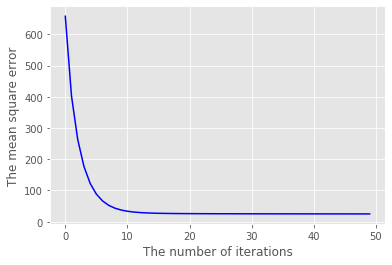

In [8]:
lr=LinearRegression(learning_rate=0.1).fit(X_train,y_train)
mean_squared_error(y_test,lr.predict(X_test))

### 4.使用随机梯度下降法

In [11]:
class LinearRegression:
    def __init__(self,learning_rate=0.03,max_iters=100):
        self.learning_rate=learning_rate
        self.max_iters=max_iters
    def fit(self,X,y):
        m,n=np.shape(X)
        X=np.insert(X,n,1,axis=1)          #将X新增一列为1的列向量
        W=np.random.randn(X.shape[1])
        loss_series=[]
        for i in range(self.max_iters):
            dataIndex=list(range(m))
            for j in range(m):
                alpha = 4/(1.0+j+i)+0.001   
                randIndex = int(np.random.uniform(0,len(dataIndex)))  #随机挑选一个样本进行迭代                       
                error=X[randIndex]@W.T-y[randIndex]
                grad=(X[randIndex].T*error)/m
                W=W-self.learning_rate*grad  #更新权重
                del (dataIndex[randIndex])
            current_loss=np.square(error).sum()/m
            loss_series.append(current_loss)
        plt.plot(range(self.max_iters),loss_series,color='blue')
        plt.xlabel('The number of iterations')
        plt.ylabel('The mean square error')
        self.W=W
        self.coef_=W[:-1]
        self.intercept=W[:-1]
        
        return self
    def predict(self,X):
        X_=np.full(shape=(X.shape[0],1),fill_value=1)
        X=np.concatenate([X,X_],axis=1)
        pre=X@self.W.T
        return pre

17.47069973309322

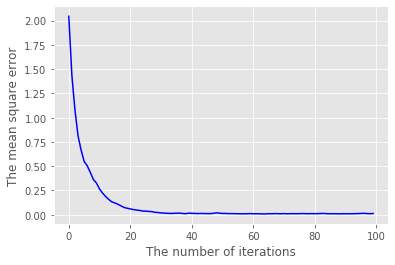

In [12]:
lr=LinearRegression(learning_rate=0.1).fit(X_train,y_train)
mean_squared_error(y_test,lr.predict(X_test))